## I. Dataset Preprocessing

### Load Dataset
After loading the D1 and D2 dataset, it can be seen that D1 dataset and D2 Dataset has the following columns:

- **D1 Dataset**:
    - training dataset, 5 columns:
        - id 
        - keyword
        - location
        - text
        - target
       
    - test dataset, 4 columns without target variable:
        - id 
        - keyword
        - location
        - text  
     
- **D2 Dataset**:
    - 4 columns: 
        - textID
        - text
        - selected_text 
        - sentiment (target column)

We will do preprocessing of the both the datasets such as imputing based on the null values the two datasets have in the following section. D1 train dataset has 7613 records and D1 test dataset has 3263 records giving a total of 10786 records for D1 dataset. D2 dataset has 27481 records.

In [1]:
import pandas as pd
import numpy as np
import torch


df_d1_train = pd.read_csv('train.csv')
df_d1_test = pd.read_csv('test.csv')
df_d2 = pd.read_csv('Tweets.csv')
df_d1 = pd.concat([df_d1_train, df_d1_test])

shape_d1_train = df_d1_train.shape
shape_d1_test = df_d1_test.shape
shape_d1 = df_d1.shape
shape_d2 = df_d2.shape

print(df_d1_train.head(), '\n')
print(df_d2.head(), '\n')
print(f'Shape of D1 train dataset is {shape_d1_train}')
print(f'Shape of D1 test dataset is {shape_d1_test}')
print(f'Shape of D1 dataset is {shape_d1}')
print(f'Shape of D2 dataset is {shape_d2}')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  

## I. Dataset Preprocessing

### Preprocessing of D1 Data

We will just be using the text as an input variable and the disaster variable as the output variable for our models using D1 dataset. Therefore, we can drop the id, keyword and location columns from both the train and test datasets of D1. The train and test dataset is then checked for null values. 



In [2]:
df_d1_train = df_d1_train.drop(['id', 'keyword', 'location'], axis=1)
df_d1_train.isna().sum()

text      0
target    0
dtype: int64

There are no null values present in d1 train dataset.

In [3]:
df_d1_test = df_d1_test.drop(['id', 'keyword', 'location'], axis=1)
df_d1_test.isna().sum()

text    0
dtype: int64

Since the test dataset does not have the target column, only text column is present and there are no null values.

Since there are no null values in both test and train datasets for D1, we do no need to do any imputing.

### Preprocessing of D2 Data

We will conduct the same analysis for D2 dataset. We will only need the test column and sentiments(target) column for our models using D2 dataset. Therfore, we drop the rest of the columns and check for null values for these two columns.

In [4]:
df_d2 = df_d2.drop(['textID', 'selected_text'], axis=1)
df_d2.isna().sum()

text         1
sentiment    0
dtype: int64

Since there is only 1 record with null value under text column. We will drop this null record from the dataset for our analysis.

In [5]:
df_d2 = df_d2.dropna()
df_d2.shape

(27480, 2)

### Preprocessing and Tokenizing the Text variable for both D1 and D2 dataset

We will combine the D1 and D2 dataset for the text columns to tokenize the text input records so that they fall under the same vocabulary when tokeninzing them. Before tokeninz them we used this TextHero package to preprocess the text input for the following:

* Lowercase all text.
* Remove all accents from strings.
* Remove all stop words.
* Remove all blocks of digits.
* Remove all string.punctuation (!"#$%&'()*+,-./:;<=>?@[]^_`{|}~).
* Replace unassigned values with empty spaces.
* Remove all white space between words

An example of the raw text and cleaned text are shown in the two tables below.

In [6]:
df_corpus = pd.concat([df_d1['text'], df_d2['text']], ignore_index = True).reset_index()

In [7]:
from transformers import DistilBertTokenizer, DistilBertModel
import texthero as hero

df_corpus['clean_text'] = hero.clean(df_corpus['text'])
df_corpus = df_corpus.drop('index', axis=1)
print(df_corpus['text'].head(10),'\n')
print(df_corpus['clean_text'].head(10),'\n')

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object 

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                              top hi

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

seqlen = df_corpus["clean_text"].apply(lambda x: len(x.split()))
print(seqlen.shape)

(38356,)


Once the text is cleaned, we used the DistilBertTokenizer which is a pre-trained NLP model tokenizer to tokenize the text inputs. After tokenizing, we need to pad the tokenized texts to make the dimensions the same for all tokenized texts. We would then use the pre-trained DistilBertModel to extract features of dimensions 768 using these padded tokens as input to the model. 

Since, the model took very long to extract the features(sentence vectors) for the text inputs from the combined D1 and D2 datasets, the extracted sentence vectors were saved as a .csv file for future loading of the vectors instead of running the model to extract the features again. These extracted sentence vectors of dimension 768 will be used as the input for the next few sections.

In [9]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Load pre-trained model (weights)
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

tokenized = df_corpus['clean_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(38356, 48)

In [ ]:
## Only ran this code once to extract the sentecnce vector using BERT model and saved
## it as a .csv file for future loading of the vector instead of runnign the code again
## as it takes long and consumes alot of memory to extract the sentence vectors from
## BERT Model - saved vectors - features.csv


from numpy import savetxt

feature_list = []
with torch.no_grad():
    for batch_idx in range(0,padded.shape[0],10):
        #BERT check 10 sample each time.
        input_ids = torch.tensor(padded[batch_idx:batch_idx+10])  
        used_attention_mask = torch.tensor(attention_mask[batch_idx:batch_idx+10])
        last_hidden_states = model(input_ids, attention_mask=used_attention_mask)
        #Get the embeddings for the [CLS] tag (position is 0)
        features = last_hidden_states[0][:,0,:]
        feature_list.append(features)

features = np.vstack(features_list)

# save features array as a .csv file for loading later
savetxt('features.csv', features, delimiter=',')


In [9]:
##Load the saved sentence vectors for both D1 and D2 text dataset
from numpy import loadtxt
# load array
features = loadtxt('features.csv', delimiter=',')
features.shape

(38356, 768)

Once the sentence vectors has been extracted using the Bert Model for the combined D1 and D2 datasets, the data is again split back to D1(both train and test dataset) and D2.The labels for the 3 class sentiments target variable were also ordinally encoded.

The datasets for D1 train dataset and D2 dataset were train-test-split with a 80%/20% ratio.

In [10]:
## split back into D1 and D2 dataset

d1_train_features = features[0:shape_d1_train[0]]
d1_test_features = features[shape_d1_train[0]:shape_d1_train[0] + shape_d1_test[0]]
d2_features = features[shape_d1_train[0] + shape_d1_test[0]:]

print(d1_train_features.shape)
print(d1_test_features.shape)
print(d2_features.shape)

def convert_2darray_to_df(arrays_2d):
    list_of_arrays = [row for row in arrays_2d]
    
    return list_of_arrays


df_d1_train['sentence_embeddings'] = convert_2darray_to_df(d1_train_features)
df_d1_test['sentence_embeddings'] = convert_2darray_to_df(d1_test_features)
df_d2['sentence_embeddings'] = convert_2darray_to_df(d2_features)

(7613, 768)
(3263, 768)
(27480, 768)


In [11]:
#pre-processed dataset of D1 train
df_d1_train

,text,target,sentence_embeddings
0,Our Deeds are the Reason of this #earthquake M...,1,"[-0.10347555577754974, 0.0949205756187439, -0...."
1,Forest fire near La Ronge Sask. Canada,1,"[-0.4164022207260132, 0.19298885762691498, -0...."
2,All residents asked to 'shelter in place' are ...,1,"[-0.2418411374092102, -0.1157110333442688, 0.1..."
3,"13,000 people receive #wildfires evacuation or...",1,"[-0.12487819045782089, 0.030626526102423668, -..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[-0.0019691395573318005, -0.14926283061504364,..."
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,"[-0.2051445096731186, 0.09096449613571167, -0...."
7609,@aria_ahrary @TheTawniest The out of control w...,1,"[-0.23618453741073608, -0.10245174914598465, -..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[-0.35735654830932617, 0.006355086341500282, 0..."
7611,Police investigating after an e-bike collided ...,1,"[-0.4586879014968872, -0.25744855403900146, -0..."


In [12]:
#pre-processed dataset of D1 test
df_d1_test

,text,sentence_embeddings
0,Just happened a terrible car crash,"[-0.25721344351768494, -0.15935777127742767, -..."
1,"Heard about #earthquake is different cities, s...","[0.02665054053068161, -0.25792196393013, 0.041..."
2,"there is a forest fire at spot pond, geese are...","[-0.21820902824401855, 0.044809360057115555, -..."
3,Apocalypse lighting. #Spokane #wildfires,"[-0.2617347240447998, 0.05129344016313553, -0...."
4,Typhoon Soudelor kills 28 in China and Taiwan,"[-0.4326396882534027, -0.2646219730377197, -0...."
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,"[-0.1371319741010666, -0.19958768784999847, 0...."
3259,Storm in RI worse than last hurricane. My city...,"[-0.0810704380273819, -0.11629102379083633, 0...."
3260,Green Line derailment in Chicago http://t.co/U...,"[-0.18644750118255615, -0.1975667029619217, -0..."
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,"[-0.421695739030838, -0.19718565046787262, -0...."


In [13]:
# Labels for both D1 and D2
from sklearn import preprocessing

D1_labels = df_d1_train['target'].values

##ordinal encoding of D2 labels - sentiments
le = preprocessing.LabelEncoder()
le.fit(['negative', 'neutral', 'positive'])
df_d2['sentiment_label'] = le.transform(df_d2['sentiment'])

In [14]:
#pre-processed dataset of D2
df_d2

,text,sentiment,sentence_embeddings,sentiment_label
0,"I`d have responded, if I were going",neutral,"[-0.08791296184062958, -0.07898502051830292, 0...",1
1,Sooo SAD I will miss you here in San Diego!!!,negative,"[-0.2562563717365265, -0.22554504871368408, 0....",0
2,my boss is bullying me...,negative,"[-0.2252037674188614, -0.052482422441244125, -...",0
3,what interview! leave me alone,negative,"[-0.060340315103530884, -0.18566212058067322, ...",0
4,"Sons of ****, why couldn`t they put them on t...",negative,"[-0.06627045571804047, -0.03680921345949173, 0...",0
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,"[-0.1049598827958107, 0.05494336783885956, 0.1...",0
27477,I`ve wondered about rake to. The client has ...,negative,"[-0.28235170245170593, -0.3820191025733948, -0...",0
27478,Yay good for both of you. Enjoy the break - y...,positive,"[0.07476642727851868, 0.024916866794228554, 0....",2
27479,But it was worth it ****.,positive,"[-0.22100362181663513, -0.1052432432770729, 0....",2


In [15]:
## Train test split into 80/20 for both D1 and D2 dataset
from sklearn.model_selection import train_test_split

D1_text_train, D1_text_val, D1_labels_train, D1_labels_val = train_test_split(df_d1_train, df_d1_train['target'], test_size=0.2, random_state=0)
D2_text_train, D2_text_val, D2_labels_train, D2_labels_val = train_test_split(df_d2, df_d2['sentiment_label'], test_size=0.2, random_state=0)

# II. Model Building

The neural network architecture consists of 3 hidden layers of 1024, 512 and 128 neurons respectively. the input layer has dimensions of 768 which is the dimension of the BERT features extraction output. The output layer is 2 (binary classification) for task 1 and 3 for task 2(multi-class classification). A dropout of 0.3 is used for each hidden layer output for prevention of overfitting. In addition, RELU is used as an activation function for the output of each hidden layer.

In [16]:
## Create dataset and dataloader for Neural network training

from torch.utils.data import Dataset, DataLoader, TensorDataset

D1_train_data = TensorDataset(torch.from_numpy(np.vstack(D1_text_train['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D1_labels_train.values).type(torch.LongTensor))
D1_train_dataloader = DataLoader(D1_train_data, batch_size=64, shuffle=True)

D1_val_data = TensorDataset(torch.from_numpy(np.vstack(D1_text_val['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D1_labels_val.values).type(torch.LongTensor))
D1_val_dataloader = DataLoader(D1_val_data, batch_size=512)

D2_train_data = TensorDataset(torch.from_numpy(np.vstack(D2_text_train['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D2_labels_train.values).type(torch.LongTensor))
D2_train_dataloader = DataLoader(D2_train_data, batch_size=128, shuffle=True)

D2_val_data = TensorDataset(torch.from_numpy(np.vstack(D2_text_val['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D2_labels_val.values).type(torch.LongTensor))
D2_val_dataloader = DataLoader(D2_val_data, batch_size=512)


In [17]:
torch.from_numpy(D2_labels_val.values).type(torch.LongTensor)

tensor([2, 1, 2,  ..., 0, 1, 0])

In [18]:
##Fully connected network with sentence vectors as inputs

import torch.nn as nn
import random
rng = 0
class NeuralNetwork(nn.Module):
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
    def __init__(self, n_classes):
        super().__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.lin4 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin4(x)
        
        return x

#### Assume the model is deployed in a server within your news agency. Explain the inputs to the model and predictions that it is expected to output. Also explain how the predictions will be used by reporters.

The inputs to the model is real time tweets from online and the output to the model is  prediction if the tweet is talking about a disaster or not. Those predicted to be disasters will be used by reporters to be further investigated for their reports on disasters that are happening in their area.

# III. Multi Task Learning

#### 1. Train the model M only for T1 in D1train. Call the trained model MD1. Evaluate MD1 on D1val and report its performance metric (F1 score) for the first task, PerfT1(MD1|D1val). Also print the confusion matrix.

Utilising just the D1 train dataset which has been split into 80%/20% for training and validation, the model described above was trained. The trained model was evaluated using the validation dateset and the results of the performance on the validation set in terms of f1 score and the confusion matrix is shown below. The loss function used was Crossentropy and the optimizer used was Adam with a learning rate of 0.0001.

In [47]:
rng = 0

torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


criterion = nn.CrossEntropyLoss()

M_D1 = NeuralNetwork(2)
optimizer = torch.optim.Adam(M_D1.parameters(), lr = 0.0001)
epochs = 20

def fit():
    for epoch in range(epochs):
        l = 0
        num_batches = 0
        for xb, yb in D1_train_dataloader:
            pred = M_D1(xb)
            loss = criterion(pred, yb)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            l += loss.detach().item()
            num_batches += 1
        print(f"Epoch {epoch}: Training loss: {l/num_batches}")
fit()

Epoch 0: Training loss: 0.5828595605368415
Epoch 1: Training loss: 0.4736311997597416
Epoch 2: Training loss: 0.4494618217771252
Epoch 3: Training loss: 0.4469677365074555
Epoch 4: Training loss: 0.4378945715725422
Epoch 5: Training loss: 0.4349824154439072
Epoch 6: Training loss: 0.4267571975166599
Epoch 7: Training loss: 0.42033909540623426
Epoch 8: Training loss: 0.4136833120137453
Epoch 9: Training loss: 0.40615985558057827
Epoch 10: Training loss: 0.4015836676893135
Epoch 11: Training loss: 0.4031594387876491
Epoch 12: Training loss: 0.3961522088696559
Epoch 13: Training loss: 0.38524199835956097
Epoch 14: Training loss: 0.3846547246600191
Epoch 15: Training loss: 0.37687573954463005
Epoch 16: Training loss: 0.3772066895229121
Epoch 17: Training loss: 0.3659581035996477
Epoch 18: Training loss: 0.3572805233610173
Epoch 19: Training loss: 0.3538552025953929


In [20]:
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

truth = []
class_probs = []
class_preds = []
with torch.no_grad():
    for data in D1_val_dataloader:
        x, y = data
        output = M_D1(x)

        class_probs_batch = [nn.Softmax(dim=0)(el) for el in output]
        _, class_preds_batch = torch.max(output, 1)
        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)
        truth.extend([l.item() for l in y])

val_probs = torch.cat([torch.stack(batch) for batch in class_probs])
val_preds = torch.cat(class_preds)

In [21]:
from sklearn.metrics import f1_score, accuracy_score

perf_t1_MD1 = f1_score(truth, val_preds)
print(f'The f1 score of MD1 based on the first task is {perf_t1_MD1}')

The f1 score of MD1 based on the first task is 0.7327823691460055


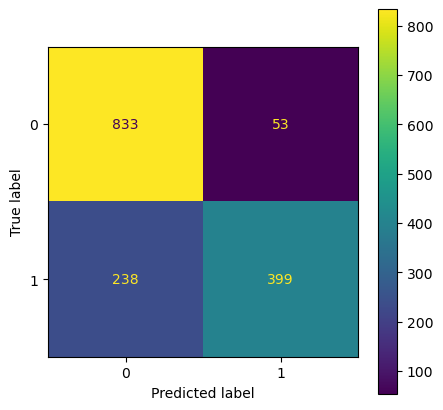

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)


disp = ConfusionMatrixDisplay(confusion_matrix(truth, val_preds, labels=[0,1]), display_labels=[0,1])
disp.plot(ax=ax)


#### 2. Train the model M only for T2 on D2train. Call the trained model MD2. Evaluate the trained MD2 on D2val and report its performance metric (Accuracy) PerfT2(MD2|D2val). Also print the confusion matrix.

Similar to the D1 train dataset, the D2 dataset was also trained and evaluated using the same model architecture. The same loss function was used. the optimizer used was Adam with a learning rate of 0.001. The results of the performance of the model on the validation set in terms of accuracy score and confusion matrix is shown below.

In [23]:

torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

criterion = nn.CrossEntropyLoss()

M_D2 = NeuralNetwork(3)
optimizer = torch.optim.Adam(M_D2.parameters(), lr = 0.001)
epochs = 20
def fit():
    for epoch in range(epochs):
        l = 0
        num_batches = 0
        for xb, yb in D2_train_dataloader:
            pred = M_D2(xb)
            loss = criterion(pred, yb)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            l += loss.detach().item()
            num_batches += 1
        print(f"Epoch {epoch}: Training loss: {l/num_batches}")
fit()

Epoch 0: Training loss: 0.8884962540726329
Epoch 1: Training loss: 0.805613188202991
Epoch 2: Training loss: 0.7828710113846978
Epoch 3: Training loss: 0.7708117878714273
Epoch 4: Training loss: 0.7674534778262294
Epoch 5: Training loss: 0.7607348835052445
Epoch 6: Training loss: 0.7571664209975753
Epoch 7: Training loss: 0.7450087125911269
Epoch 8: Training loss: 0.7440101119667984
Epoch 9: Training loss: 0.7434442947770274
Epoch 10: Training loss: 0.7371547967195511
Epoch 11: Training loss: 0.7290339611990507
Epoch 12: Training loss: 0.7255553672480028
Epoch 13: Training loss: 0.7231831543667372
Epoch 14: Training loss: 0.7185053243193515
Epoch 15: Training loss: 0.715627055528552
Epoch 16: Training loss: 0.7097152786892514
Epoch 17: Training loss: 0.7029003556384597
Epoch 18: Training loss: 0.7025264186221499
Epoch 19: Training loss: 0.6973349545584169


In [24]:
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


truth = []
class_probs = []
class_preds = []
with torch.no_grad():
    for data in D2_val_dataloader:
        x, y = data
        output = M_D2(x)
        
        class_probs_batch = [nn.Softmax(dim=0)(el) for el in output]
        _, class_preds_batch = torch.max(output, 1)
        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)
        truth.extend([l.item() for l in y])

val_probs = torch.cat([torch.stack(batch) for batch in class_probs])
val_preds = torch.cat(class_preds)

In [25]:

perf_t2_MD2 = accuracy_score(val_preds, truth)
print(f'The accuracy score of MD2 based on the second task is {perf_t2_MD2}')

The accuracy score of MD2 based on the second task is 0.637372634643377


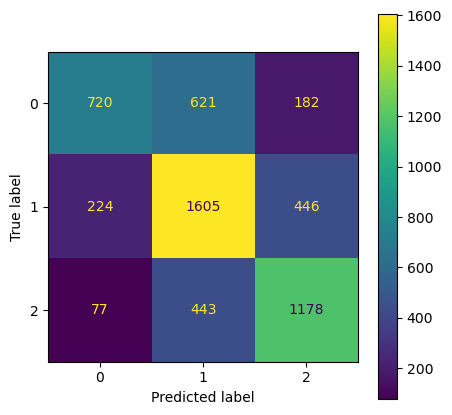

In [26]:
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)


disp = ConfusionMatrixDisplay(confusion_matrix(truth, val_preds, labels=[0,1,2]), display_labels=[0,1,2])
disp.plot(ax=ax)

#### 3. Estimate the sentiment labels for the tweets in D1.

An augmented dataset of D1 was created by using the model trained using D2 dataset to predict the sentiment labels for the tweets from the D1 dataset. 

In [27]:
with torch.no_grad():
    output = M_D2(torch.from_numpy(np.vstack(df_d1_train['sentence_embeddings'].values)).type(torch.float32))
    class_probs = [nn.Softmax(dim=0)(el) for el in output]
    _, class_preds = torch.max(output, 1)
    D1_labels_train_hat = class_preds.numpy()

#Augmented dataset df
df_d1_train_aug =  df_d1_train.copy()
df_d1_train_aug['sentiment_label'] = convert_2darray_to_df(D1_labels_train_hat)



In [28]:
df_d1_train_aug

,text,target,sentence_embeddings,sentiment_label
0,Our Deeds are the Reason of this #earthquake M...,1,"[-0.10347555577754974, 0.0949205756187439, -0....",2
1,Forest fire near La Ronge Sask. Canada,1,"[-0.4164022207260132, 0.19298885762691498, -0....",1
2,All residents asked to 'shelter in place' are ...,1,"[-0.2418411374092102, -0.1157110333442688, 0.1...",1
3,"13,000 people receive #wildfires evacuation or...",1,"[-0.12487819045782089, 0.030626526102423668, -...",1
4,Just got sent this photo from Ruby #Alaska as ...,1,"[-0.0019691395573318005, -0.14926283061504364,...",1
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,"[-0.2051445096731186, 0.09096449613571167, -0....",0
7609,@aria_ahrary @TheTawniest The out of control w...,1,"[-0.23618453741073608, -0.10245174914598465, -...",0
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[-0.35735654830932617, 0.006355086341500282, 0...",1
7611,Police investigating after an e-bike collided ...,1,"[-0.4586879014968872, -0.25744855403900146, -0...",0


#### Analyze and report the predicted sentiment labels for some of the tweets from the disaster dataset. Use at least 1 tweet from each class for your analysis.

In [29]:
print("Examples of negative sentiments:")
print('Texts:')
print("1.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 0].iloc[0,0])
print("2.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 0].iloc[1,0])
print("3.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 0].iloc[3,0])
print("\n")

print("Examples of positive sentiments:")
print('Text:')
print("1.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 2].iloc[0,0])
print("2.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 2].iloc[1,0])
print("3.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 2].iloc[2,0])
print("\n")

print("Examples of neutral sentiments:")
print('Text:')
print("1.", df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 1].iloc[0,0])
print("2.",df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 1].iloc[1,0])
print("3.",df_d1_train_aug[df_d1_train_aug['sentiment_label'] == 1].iloc[2,0])

Examples of negative sentiments:
Texts:
1. #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
2. Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
3. Damage to school bus on 80 in multi car crash #BREAKING 


Examples of positive sentiments:
Text:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. I love fruits
3. Summer is lovely


Examples of neutral sentiments:
Text:
1. Forest fire near La Ronge Sask. Canada
2. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3. 13,000 people receive #wildfires evacuation orders in California 


As shown in the examples above for the predicted negative, positive and nuetral sentiments, it is able to correctly predict the postive sentiments and negative sentiments(disaster tweets) relatively well. However, the neutral sentiments are not that well predicted as alot of the disaster tweets are predicted as neutral.

#### 4. Create another dataset by combining D1 and D2:

Another dataset was also created where the D1 train dataset was merged with the D2 train dataset with both labels and tweets. In this dataset, whereever the labels are missing for each tweet, it is retained as null. The combined dataset is shown below.

In [30]:
D1_D2_train_combine_df = D1_text_train.merge(D2_text_train, on='text', how='outer').drop(['sentiment'], axis=1)

D1_D2_train_combine_df = D1_D2_train_combine_df.rename(columns = {'sentence_embeddings_x': 'sentence_embeddings_D1', 'sentence_embeddings_y': 'sentence_embeddings_D2'})

def sentence_embeddings_combine(row):
    if np.isnan(row['sentence_embeddings_D1']).all():
        return row['sentence_embeddings_D2']
    else:
        return row['sentence_embeddings_D1']
    
D1_D2_train_combine_df['sentence_embeddings'] = D1_D2_train_combine_df.apply(sentence_embeddings_combine, axis=1)
D1_D2_train_combine_df = D1_D2_train_combine_df.drop(['sentence_embeddings_D1', 'sentence_embeddings_D2'], axis=1)


In [31]:
D1_D2_train_combine_df

,text,target,sentiment_label,sentence_embeddings
0,Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...,0.0,NaN,"[-0.20338654518127441, -0.14267973601818085, -..."
1,This is the first year the Forest Service spen...,1.0,NaN,"[-0.32133790850639343, -0.10172615945339203, -..."
2,@lightseraphs pissed at you and could have the...,0.0,NaN,"[-0.09641452133655548, -0.19245226681232452, 0..."
3,I'm gonna fight Taylor as soon as I get there.,0.0,NaN,"[-0.04530864953994751, -0.041303567588329315, ..."
4,@NicolaClements4 IÛªm not sure that covering ...,0.0,NaN,"[-0.4246214032173157, 0.0069144354201853275, 0..."
...,...,...,...,...
28069,...thanks for the shout out...you might be ri...,NaN,2.0,"[-0.09515293687582016, 0.06759532541036606, 0...."
28070,"Im going in now, it looks like the sun has gone",NaN,1.0,"[-0.07051143795251846, 0.21059899032115936, 0...."
28071,I am soooo saying this phrase now 'Stop be so ...,NaN,1.0,"[-0.1425376832485199, 0.03949875757098198, 0.0..."
28072,Morning all and its a lovely day at last,NaN,2.0,"[-0.1805098056793213, -0.27493786811828613, 0...."


#### 5. Train M for both T1 and T2 on D12 by minimizing a weighted loss, λ1l1 + λ2l2 where λs are positive scalar weights between and 1: higher the λ more the emphasis on corresponding task while training; l1, l2 are task-specific loss functions. Call this model MD12.


A multitask learning(MTL) model was built using the same architecture as the individual models stated in previous sections. Using the merged dataset in Section 4, the model is trained for both tasks. A simple schematic of the model is shown below.

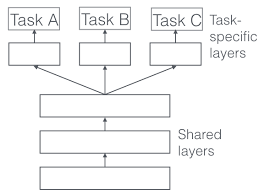

This MTL model is described as a hard parameter sharing model where both the tasks share the same hidden layers. Therefore, the weights are the same for the hidden layers for both the tasks. A hyperparameter term lambda1 and lambda2 is used to combine the loss function for the gradients to be computed and the weights to be updated in each batch as part of the training.

#### When the label of a data sample is , the corresponding loss is considered as 0. What is the effect of this during network training?

If a label is null for a particular observation, the loss is calculated as zero for that particular task. The loss from this lable is not use for backpropagation to update the weights for the shared hidden layers. This just means that the model is trained focusing on the task which has a label and not focus on the task where the label is null as the weights are updated at each batch based on the combined loss function. 

The model MD12 is trained using the combined dataset and the performance of the model is evaluated using the validation set(20% split) of the augmented dataset. A lambda value of 0.5 is used for both lambdas. The evaluation in terms of f1 score for task 1 and accuracy score for task 2 is shown below. The confusion matrices for both tasks on the validation dataset are also detailed below.

In [32]:
#Multi-task model Architecture
class MultiTaskNeuralNetwork(nn.Module):
    def __init__(self, n_classes_task1, n_classes_task2):
        super().__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.3)
        
        # Task-specific output layers
        self.out_task1 = nn.Linear(128, n_classes_task1)
        self.out_task2 = nn.Linear(128, n_classes_task2)
        
    def forward(self, x, task):
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # Task-specific outputs
        if task == 1:
            return self.out_task1(x)
        if task == 2:
            return self.out_task2(x)

In [34]:
D12_train_data = TensorDataset(torch.from_numpy(np.vstack(D1_D2_train_combine_df['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D1_D2_train_combine_df['target'].values), torch.from_numpy(D1_D2_train_combine_df['sentiment_label'].values))
D12_train_dataloader = DataLoader(D12_train_data, batch_size=64, shuffle=True)



In [35]:
test_dataset = TensorDataset(torch.from_numpy(D1_D2_train_combine_df['target'].values))
test_dataloader = DataLoader(test_dataset, batch_size=28074, shuffle=True)

#### After training with λ1 = λ2 = 0.5, evaluate MD12 on D1_hat_val and report the performance for both the tasks. Print confusion matrices for both.

In [36]:
# Train model with lambda1 = 0.5 and lambda2 = 0.5 - Hyperparameters for the loss functions
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

lambda_1 = 0.5
lambda_2 = 0.5
epochs = 20

MD_12 = MultiTaskNeuralNetwork(n_classes_task1=2, n_classes_task2=3)

# Define separate loss functions for each task
criterion_task1 = nn.CrossEntropyLoss()
criterion_task2 = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(MD_12.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2]
        
        # Forward pass
        #outputs_task1, outputs_task2 = MD_12(inputs)
        outputs_task1 = MD_12(input1, task=1)
        outputs_task2 = MD_12(input2, task=2)
        
        #print(labels_task1)
        # Compute the losses for each task
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Combine the losses with the hyperparameters as factors
        loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

Epoch 1, Loss: 0.5301852797185641
Epoch 2, Loss: 0.4304850555633901
Epoch 3, Loss: 0.41082929468507917
Epoch 4, Loss: 0.40112957229375296
Epoch 5, Loss: 0.39383074817733504
Epoch 6, Loss: 0.3895439106402473
Epoch 7, Loss: 0.38536120038097704
Epoch 8, Loss: 0.3803299713650706
Epoch 9, Loss: 0.3758257447926493
Epoch 10, Loss: 0.37180413068155493
Epoch 11, Loss: 0.36785031770247806
Epoch 12, Loss: 0.3660173841788177
Epoch 13, Loss: 0.36170643554461573
Epoch 14, Loss: 0.35800651795228683
Epoch 15, Loss: 0.35379083461397604
Epoch 16, Loss: 0.34999145268715054
Epoch 17, Loss: 0.34694199725680036
Epoch 18, Loss: 0.3426519400505922
Epoch 19, Loss: 0.33846259049239624
Epoch 20, Loss: 0.33417507795646684


In [37]:
D1_hat_train, D1_hat_val = train_test_split(df_d1_train_aug, test_size=0.2, random_state=0)

In [38]:
#Dataloader for D1_hat for validation
D1_hat_val_data = TensorDataset(torch.from_numpy(np.vstack(D1_hat_val['sentence_embeddings'].values)).type(torch.float32), torch.from_numpy(D1_hat_val['target'].values).type(torch.LongTensor), torch.from_numpy(D1_hat_val['sentiment_label'].values).type(torch.LongTensor))
D1_hat_val_dataloader = DataLoader(D1_hat_val_data, batch_size=512)

In [506]:
#Evaluation of model using D1_hat validation data
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

truth1 = []
truth2 = []
class_probs_t1 = []
class_probs_t2 = []
class_preds_t1 = []
class_preds_t2 = []

with torch.no_grad():
    for data in D1_hat_val_dataloader:
        x, y1, y2 = data
        output_t1 = MD_12(x, task = 1)
        output_t2 = MD_12(x, task = 2)
        
        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
        class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]
        
        _, class_preds_t1_batch = torch.max(output_t1, 1)
        _, class_preds_t2_batch = torch.max(output_t2, 1)

        class_probs_t1.append(class_probs_t1_batch)
        class_probs_t2.append(class_probs_t2_batch)
        
        class_preds_t1.append(class_preds_t1_batch)
        class_preds_t2.append(class_preds_t2_batch)
        
        truth1.extend([l.item() for l in y1])
        truth2.extend([l.item() for l in y2])

val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
val_preds_t1 = torch.cat(class_preds_t1)
val_preds_t2 = torch.cat(class_preds_t2)

In [507]:
#Task 1 and Task 2 performance score for lambda1=0.5 and lambda2=0.5
perf_t1_MD12 = f1_score(truth1, val_preds_t1)
print(f'The f1 score of MD12 based on the first task is {perf_t1_MD12}')

perf_t2_MD12 = accuracy_score(truth2, val_preds_t2)
print(f'The accuracy score of MD12 based on the second task is {perf_t2_MD12}')

The f1 score of MD12 based on the first task is 0.7418502202643172
The accuracy score of MD12 based on the second task is 0.41628365068942874


the confusion matrix of task 1 from MD12 model is:


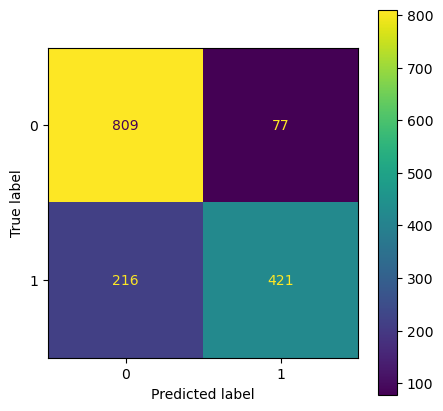

In [508]:
#Confusion Matrix for task 1 for lambda1=0.5 and lambda2=0.5
print('the confusion matrix of task 1 from MD12 model is:')
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix(truth1, val_preds_t1, labels=[0,1]), display_labels=[0,1])
disp.plot(ax=ax)

the confusion matrix of task 2 from MD12 model is:


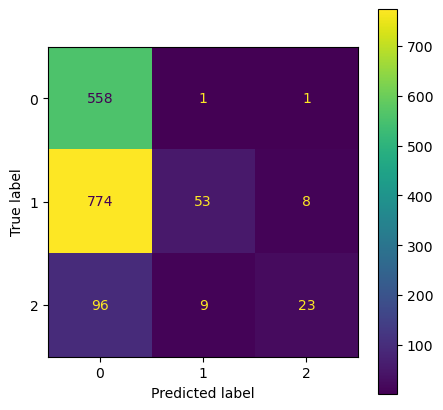

In [509]:
#Confusion Matrix for task 2 for lambda1=0.5 and lambda2=0.5
print('the confusion matrix of task 2 from MD12 model is:')
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix(truth2, val_preds_t2, labels=[0,1,2]), display_labels=[0,1,2])
disp.plot(ax=ax)

### 6. Obtain the best values of the hyperparameters to optimise for classification for Task 1.

To optimise the model based on our primary task 1 performance, the hyperparameters lambda1 and lambda2 are gridsearched(each lambda ranging from 0 to 1) to find the best combination that gives the best performance for task 1 which is our primary task. The results of the hyperparameter tuning exercise is shown below.

In [524]:
## Create a function to train and evaluate the model based on a given 
## lambda1 and lambda2

def train_and_evaluate_model(lambda_1, lambda_2, train_dataloader, val_dataloader):
    
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    MD_12 = MultiTaskNeuralNetwork(n_classes_task1=2, n_classes_task2=3)

    epochs = 20

    # Define separate loss functions for each task
    criterion_task1 = nn.CrossEntropyLoss()
    criterion_task2 = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(MD_12.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        for (inputs, labels_task1, labels_task2) in train_dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            idx1 = labels_task1 != np.nan
            idx2 = labels_task2 != np.nan
            input1 = inputs[idx1]
            input2 = inputs[idx2]

            # Forward pass
            outputs_task1 = MD_12(input1, task=1)
            outputs_task2 = MD_12(input2, task=2)

            # Compute the losses for each task
            loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
            loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

            # Combine the losses with the hyperparameters as factors
            loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the running loss
            running_loss += loss.item()

        # # Print the average loss for this epoch
        #print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

    #Evalution of model
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    truth1 = []
    truth2 = []
    class_probs_t1 = []
    class_probs_t2 = []
    class_preds_t1 = []
    class_preds_t2 = []
    
    with torch.no_grad():
        for data in val_dataloader:
            x, y1, y2 = data
            output_t1 = MD_12(x, task = 1)
            output_t2 = MD_12(x, task = 2)

            class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
            class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]

            _, class_preds_t1_batch = torch.max(output_t1, 1)
            _, class_preds_t2_batch = torch.max(output_t2, 1)

            class_probs_t1.append(class_probs_t1_batch)
            class_probs_t2.append(class_probs_t2_batch)

            class_preds_t1.append(class_preds_t1_batch)
            class_preds_t2.append(class_preds_t2_batch)

            truth1.extend([l.item() for l in y1])
            truth2.extend([l.item() for l in y2])

    val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
    val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
    val_preds_t1 = torch.cat(class_preds_t1)
    val_preds_t2 = torch.cat(class_preds_t2)    
    
    perf_t1_MD12 = f1_score(truth1, val_preds_t1)
    perf_t2_MD12 = accuracy_score(truth2, val_preds_t2)    

    return perf_t1_MD12, perf_t2_MD12


In [525]:
#do a gridsearch on lambda1 and lambda2 to find best lambdas for task 1 performance
lambda_1_list = [0, 0.25, 0.5, 0.75, 1.0] 
lambda_2_list = [0, 0.25, 0.5, 0.75, 1.0]
best_lambda_1 = None
best_lambda_2 = None
best_t1_val_perf = 0

## Run all combinations of lambda1 and lambda2 to find best combination for best 
## T1 performance
for lambda_1 in lambda_1_list:

    for lambda_2 in lambda_2_list:
        
        task1_val_perf, task2_val_perf = train_and_evaluate_model(lambda_1, lambda_2, D12_train_dataloader, D1_hat_val_dataloader)
        
        print(f"Lambda_1: {lambda_1}, Lambda_2: {lambda_2}, Task 1 Validation f1_score: {task1_val_perf}")
        
        if task1_val_perf > best_t1_val_perf:
            best_t1_val_perf = task1_val_perf
            best_lambda_1 = lambda_1
            best_lambda_2 = lambda_2

Lambda_1: 0, Lambda_2: 0, Task 1 Validation f1_score: 0.5863039399624765
Lambda_1: 0, Lambda_2: 0.25, Task 1 Validation f1_score: 0.008849557522123894
Lambda_1: 0, Lambda_2: 0.5, Task 1 Validation f1_score: 0.0029629629629629632
Lambda_1: 0, Lambda_2: 0.75, Task 1 Validation f1_score: 0.0029761904761904765
Lambda_1: 0, Lambda_2: 1.0, Task 1 Validation f1_score: 0.0
Lambda_1: 0.25, Lambda_2: 0, Task 1 Validation f1_score: 0.7530017152658661
Lambda_1: 0.25, Lambda_2: 0.25, Task 1 Validation f1_score: 0.7542147293700089
Lambda_1: 0.25, Lambda_2: 0.5, Task 1 Validation f1_score: 0.74447391688771
Lambda_1: 0.25, Lambda_2: 0.75, Task 1 Validation f1_score: 0.7405452946350043
Lambda_1: 0.25, Lambda_2: 1.0, Task 1 Validation f1_score: 0.7430025445292621
Lambda_1: 0.5, Lambda_2: 0, Task 1 Validation f1_score: 0.7564766839378237
Lambda_1: 0.5, Lambda_2: 0.25, Task 1 Validation f1_score: 0.74447391688771
Lambda_1: 0.5, Lambda_2: 0.5, Task 1 Validation f1_score: 0.7418502202643172
Lambda_1: 0.5, L

In [550]:
print(f"The best lambda_1 value is: {best_lambda_1}")
print(f"The best lambda_2 value is: {best_lambda_2}")

The best lambda_1 value is: 0.5
The best lambda_2 value is: 0


#### 7. Train the model on with the best λs obtained in step 6. Evaluate it on D1test for the tasks and report PerfT1(M*D12|D1test) by participating in the challenge. Submit a screenshot of your leaderboard score and position.

The best lambdas to use for the best performance for task 1 is lambda1 = 0.5 and lambda2 = 0. These hyperparameters are used to re-train the model. The re-trained optimised for task 1 model is then used to predict the labels for the D1 test dataset to be submitted in Kaggle.

In [39]:
# Re-train model with lambda_1 = 0.5 and lambda_2 = 0
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

lambda_1 = 0.5
lambda_2 = 0.0
epochs = 20

MD_12_test = MultiTaskNeuralNetwork(n_classes_task1=2, n_classes_task2=3)
# Define separate loss functions for each task
criterion_task1 = nn.CrossEntropyLoss()
criterion_task2 = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(MD_12_test.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2]        
        
        # Forward pass
        outputs_task1 = MD_12_test(input1, task=1)
        outputs_task2 = MD_12_test(input2, task=2)

        # Compute the losses for each task
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Combine the losses with the hyperparameters as factors
        loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

Epoch 1, Loss: 0.08508400533535011
Epoch 2, Loss: 0.061049835463659094
Epoch 3, Loss: 0.05886150733408665
Epoch 4, Loss: 0.05695856657252564
Epoch 5, Loss: 0.05533848590469985
Epoch 6, Loss: 0.05416584508238967
Epoch 7, Loss: 0.052747852484014625
Epoch 8, Loss: 0.051984266274033755
Epoch 9, Loss: 0.051056703271509775
Epoch 10, Loss: 0.0503111632762515
Epoch 11, Loss: 0.04981572580139804
Epoch 12, Loss: 0.04833769537126624
Epoch 13, Loss: 0.048265669159676054
Epoch 14, Loss: 0.04663654399774799
Epoch 15, Loss: 0.046400111095962836
Epoch 16, Loss: 0.045006322100597324
Epoch 17, Loss: 0.043547674485297706
Epoch 18, Loss: 0.0428064103038867
Epoch 19, Loss: 0.04138571462659738
Epoch 20, Loss: 0.0403988613823433


In [40]:
# load D1 test file with ID column and concat with original D1 test df
df_d1_test_id = pd.read_csv('test.csv')
df_d1_test_id = df_d1_test_id['id']
df_d1_test_final = pd.concat([df_d1_test_id, df_d1_test], axis=1)

# D1 test dataset in dataset loader
test_dataset = TensorDataset(torch.from_numpy(np.vstack(df_d1_test_final['sentence_embeddings'].values)).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=3263)

In [627]:
# Predict trained model test dataset to be submitted in Kaggle
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


class_probs_t1 = []
class_preds_t1 = []
with torch.no_grad():
    for data in test_dataloader:
        x = data
        output_t1 = MD_12_test(x[0], task = 1)
        
        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
        
        _, class_preds_t1_batch = torch.max(output_t1, 1)

        class_probs_t1.append(class_probs_t1_batch)
        
        class_preds_t1.append(class_preds_t1_batch)
        

#predictions of D1 test data
val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_preds_t1 = torch.cat(class_preds_t1).numpy()

#write prediction of test data to output for submission to kaggle
df_d1_MD12_test_preds = df_d1_test_final
df_d1_MD12_test_preds['target'] = val_preds_t1.tolist()
df_d1_MD12_test_preds = df_d1_MD12_test_preds.drop(['text', 'sentence_embeddings'], axis=1)
df_d1_MD12_test_preds.to_csv('test_hard_parameter.csv', index=False)

### The model resulted in Score of 80.14% in Kaggle.(Please refer screenshot in the zip file)

#### 8. In step 7, you performed multi-task learning, where data for the second taskis externally sourced. Is the best value of hyper-parameter λ2 from step 6 zero or positive, i.e., is λ2 = 0 or λ2 > 0 ? What does the value of λ2 convey? Does the externally sourced sentiment data improve the model accuracy for our primary task of disaster classification?

As shown in the results above, the best results for predicting task 1 is when lambda2 is zero. This means that when lambda2 is zero, the model is more focused on training for the task 1 as it only updates the weights based on the gradient of the loss function of task 1 during backpropagation. The value of lambda2 conveys the importance we want to give to task 2 prediction when training the model.

However, we would expect the model to give the same results as MD1 model in section 1 as lambda2 is zero(loss function for task2 is always zero) and that would mean the backpropagation to update the weights would only be done using loss fuction for task 1. But we are getting better slightly better results with MD12 model compared to MD1 model. This is probably due to using a larger dataset (combine D1 and D2). While training backpropagation per batch, a combination of D1 and D2 data is passed for loss calculation compared to just D1 data alone in MD1 model. Therefore, the backpropagation and loss calculation is different in MD12 model compared to MD1 model even though the loss function is calculated only using D1 dataset for both (lambda2 is zero). 

Therefore, using the externally sourced sentiment data does improve the overall accuracy of task 1 using the MTL model MD12 compared to only training the model based on D1 train dataset as shown in section 1 as it improves generalizability of the predictions by preventing overfitting to D1 dataset alone.

#### 9. For multi-task learning why is the augmented dataset D1_hat used only for testing but not for training?

The augmented dataset is used only for testing and not for training due to the fact that the labels used for sentiments in the augmented dataset are not true labels and are predicted from the model trained using the D2 dataset. As the prediction accuracy is low for the model trained using the D2 dataset as shown in Section 2, the labels will not be suitable for training them as true labels in the MTL model. Since we are testing for our primary task, the augmented dataset can be used for testing as the labels for task 1 are true labels in the augmented dataset.

# Part IV: Random Forest

#### 1. How can the MTL strategy of loss combination in question 5 (part III) be used with a Random Forest? Explain.

Random Forests are a type of decision tree-based ensemble model that doesn't use a loss function during training. Instead, the Random Forest algorithm trains decision trees on random subsets of the input data and features, and combines the results to make predictions.One way to do this is to modify the splitting criterion of the decision trees to take into account the multi-task objective

The Information Gain and Gain Ratio criteria of each split Si is calculated by combine the main classification
task and the second task, showing below.

MTIG(Si) = MainTaskIG(Si) + weight ∗ SecondTaskIG(Si) 

In this equation, MainTaskIG(Si) is the information gain of the main task, which is the task that is being optimized in the decision tree split. SecondTaskIG(Si) is the information gain of the extra task, which is a related task that is being considered along with the main task.

The weight parameter in the equation is a tuning parameter that determines the relative importance of the main task and the Second task in the decision-making process.

#### 2.  Try the following approach: Use the augmented dataset obtained in question 3 (part III) to train a Random Forest for prediction of label 1, use the predicted sentiment labels for weighting the samples while fitting the Random Forest.Evaluate the model on D1_hat_val and report the performance and print confusion matrix

Here we have trained a random forest model using the augmented dataset.We have randomly selected below lambda values(equal sample weights).

lambda_p = 0.5
lambda_n = 0.5
lambda_0 = 0.5

In [54]:
from sklearn.ensemble import RandomForestClassifier

#Extracting the sentence embedding from train data
X_train = np.vstack(D1_hat_train['sentence_embeddings'].values)
y_train = D1_hat_train['target']
train_label_2 = D1_hat_train['sentiment_label']

#Extracting the sentence embedding from validation data
X_val = np.vstack(D1_hat_val['sentence_embeddings'].values)
y_val = D1_hat_val['target']


#Sentiment Label Weights chosen randomly: 
lambda_p = 0.5
lambda_n = 0.5
lambda_0 = 0.5

#Assignng weights to the samples
sample_weights_label2 = np.where(train_label_2 == 2, lambda_p,
                          np.where(train_label_2 == 0, lambda_n,
                          lambda_0))

# create a Random Forest model with sample weights
model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state = 0)

# fit the model using sample weights
model.fit(X_train, y_train, sample_weight = sample_weights_label2)





RandomForestClassifier(criterion='entropy', random_state=0)

In [55]:
#Running predictions on validation dataset
y_val_pred = model.predict(X_val)

In [56]:
perf_t1_RF = f1_score(y_val, y_val_pred)
print(f'The f1 score of Random Forest based on the first task is {perf_t1_RF}')

The f1 score of Random Forest based on the first task is 0.7335640138408305


the confusion matrix Random Forest based on the first task is:


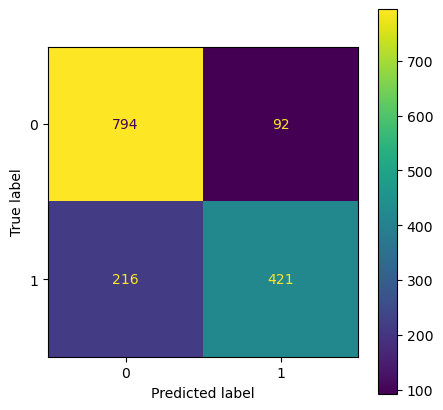

In [46]:
print('the confusion matrix Random Forest based on the first task is:')
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred, labels=[0,1]), display_labels=[0,1])
disp.plot(ax=ax)

### 3. Use any hyper parameter tuning method to find the best values lambdas to maximize PerfT1(M ̂ D train1| ̂ D val1 ). Is the optimal value result in  lambda_p = lambda_n = lambda_0? If not what is the ordering of the lambdas , and what can we infer from this ordering?

In [57]:
#List of lamdas generated to try different combinations as part of hyperparameter tuning between 0.2 to 1

lambda_p_list = np.arange(0.2, 1.1, 0.2)
print("lambda_p_list ",lambda_p_list)
lambda_n_list = np.arange(0.2, 1.1, 0.2)
print("lambda_n_list ",lambda_n_list)
lambda_0_list = np.arange(0.2, 1.1, 0.2)
print("lambda_0_list ",lambda_0_list)

lambda_p_list  [0.2 0.4 0.6 0.8 1. ]
lambda_n_list  [0.2 0.4 0.6 0.8 1. ]
lambda_0_list  [0.2 0.4 0.6 0.8 1. ]


In [58]:
best_lambda_p = None
best_lambda_n = None
best_lambda_0 = None
best_perf_t1_RF = 0

for lambda_p in lambda_p_list:

    for lambda_n in lambda_n_list:
        
        for lambda_0 in lambda_0_list:
            
            sample_weights_label2 = np.where(train_label_2 == 2, lambda_p,
                          np.where(train_label_2 == 0, lambda_n,
                          lambda_0))
            # fit the model using sample weights
            model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state = 0)
            model.fit(X_train, y_train, sample_weight = sample_weights_label2)
            y_val_pred = model.predict(X_val)
            perf_t1_RF = f1_score(y_val, y_val_pred)
            
            print(f"Lambda_p: {lambda_p}, Lambda_n: {lambda_n}, Lambda_0: {lambda_0}, Task 1 Validation f1_score: {perf_t1_RF}")
            
            if perf_t1_RF > best_perf_t1_RF:
                best_perf_t1_RF = perf_t1_RF
                best_lambda_p = lambda_p
                best_lambda_n = lambda_n
                best_lambda_0 = lambda_0


Lambda_p: 0.2, Lambda_n: 0.2, Lambda_0: 0.2, Task 1 Validation f1_score: 0.7372072853425845
Lambda_p: 0.2, Lambda_n: 0.2, Lambda_0: 0.4, Task 1 Validation f1_score: 0.7334494773519163
Lambda_p: 0.2, Lambda_n: 0.2, Lambda_0: 0.6000000000000001, Task 1 Validation f1_score: 0.7352941176470588
Lambda_p: 0.2, Lambda_n: 0.2, Lambda_0: 0.8, Task 1 Validation f1_score: 0.7334494773519163
Lambda_p: 0.2, Lambda_n: 0.2, Lambda_0: 1.0, Task 1 Validation f1_score: 0.7236268526591109
Lambda_p: 0.2, Lambda_n: 0.4, Lambda_0: 0.2, Task 1 Validation f1_score: 0.7272727272727272
Lambda_p: 0.2, Lambda_n: 0.4, Lambda_0: 0.4, Task 1 Validation f1_score: 0.7396551724137931
Lambda_p: 0.2, Lambda_n: 0.4, Lambda_0: 0.6000000000000001, Task 1 Validation f1_score: 0.7234416154521511
Lambda_p: 0.2, Lambda_n: 0.4, Lambda_0: 0.8, Task 1 Validation f1_score: 0.7226596675415574
Lambda_p: 0.2, Lambda_n: 0.4, Lambda_0: 1.0, Task 1 Validation f1_score: 0.7275892080069625
Lambda_p: 0.2, Lambda_n: 0.6000000000000001, Lambd

In [59]:
#Best F1-Score on validation data
best_perf_t1_RF

0.7445887445887446

In [60]:
#Best Weights for postive samples
best_lambda_p

0.8

In [61]:
#Best Weights for negative samples
best_lambda_n

1.0

In [62]:
#Best Weights for neutral samples
best_lambda_0

0.6000000000000001

The optimal values does not result in best_lambda_p = best_lambda_n = best_lambda_0.

lambda_p = 0.8
lambda_n = 1.0
lambda_0 = 0.6

#### best_lambda_n > best_lambda_p > best_lambda_0


This indicates that the model is encouraged to rely more heavily on Negative sentiment data samples when compared to positive and neutral data.

The model is then retrained using the optimal lambdas and used to predict on the test dataset. The results of the prediction are then submitted in Kaggle.

In [71]:
# Using best Lamba values we got from grid search

#Sentiment Label Weights
lambda_p = 0.8
lambda_n = 1.0
lambda_0 = 0.6


sample_weights_label2 = np.where(train_label_2 == 2, lambda_p,
                          np.where(train_label_2 == 0, lambda_n,
                          lambda_0))

# create a Random Forest model with sample weights
model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state = 0)

# fit the model using sample weights
model.fit(X_train, y_train, sample_weight = sample_weights_label2)

RandomForestClassifier(criterion='entropy', random_state=0)

In [74]:
y_val_pred = model.predict(X_val)

perf_t1_RF = f1_score(y_val, y_val_pred)
print(f'The f1 score of Random Forest based on the first task is {perf_t1_RF}')

The f1 score of Random Forest based on the first task is 0.7334494773519163


In [91]:
X_test = np.vstack(df_d1_test['sentence_embeddings'].values)

In [92]:
y_test_pred = model.predict(X_test)

In [93]:
output = pd.DataFrame({'id': df_d1_test.id,
                       'target': y_test_pred})

In [94]:
output.to_csv('submission.csv')

### The model resulted in Score of 79.16% in Kaggle.(Please refer screenshot in the zip file)

# V. Further Exploration

## 1. Soft-Parameter Sharing Multi-Task Learning Model

Similar to the hard parameter sharing MTL model shown in section 5, a soft-parameter sharing MTL model was explored. A simple schematic of the soft parameter sharing model is shown below.

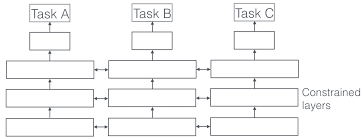

In this model, instead of both tasks sharing the hidden layers and the same weights, each task has its own model and hidden layers. However, the weights of the hidden layers are regularised to train the weights to be similar but not the same (as in hard parameter sharing MTL model). This may give some flexibility in the model to learn specific components of each tasks even though the weights are similar for both tasks.

For this MTL model, two models (with the same architecture) are trained separately with its own loss function and optimiser for each task. However, each loss function for each task has a regularisation term which takes into account the difference in weights of the hidden layers between the two tasks models. This is to train both models to have similar weights in their hidden layers. A hyperparameter lambda is used to test the magnitude of the regularisation term that is needed to give the best results based on the requirements.

For our case, since the primary task is task 1, we would like to hyper parameter tune the lambda to give the best performance for task 1 based on the validation set. 
The performance of the model for task1 using lambda=0.1 based on the validation dataset is shown below.

In [434]:
## Soft parameter sharing model
class NeuralNetworkTask1(nn.Module):
    
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    def __init__(self, n_classes):
        super().__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.lin4 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin4(x)
        
        return x

class NeuralNetworkTask2(nn.Module):
 
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    def __init__(self, n_classes):
        super().__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.lin4 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin4(x)
        
        return x

In [529]:
# Training the softparameter sharing model for lambda = 0.1
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

network1 = NeuralNetworkTask1(2)
network2 = NeuralNetworkTask2(3)

# Define the loss functions
criterion_task1 = torch.nn.CrossEntropyLoss()
criterion_task2 = torch.nn.CrossEntropyLoss()

# Define the optimizers
optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.0001)

# Hyperparameter for controlling the weight similarity
lambda_value = 0.1

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    l1 = 0
    l2 = 0
    num_batches = 0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:

        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2] 

        #optimizer2.zero_grad()
        # Forward pass for both tasks
        outputs_task1 = network1(input1)
        outputs_task2 = network2(input2)

        # Calculate the losses for both tasks
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Calculate the regularization term
        regularization_term = (
            torch.norm(network1.lin1.weight - network2.lin1.weight, 2) +
            torch.norm(network1.lin2.weight - network2.lin2.weight, 2) +
            torch.norm(network1.lin3.weight - network2.lin3.weight, 2)
        )

        # Add the regularization term to the losses
        total_loss_task1 = loss_task1 + + lambda_value * regularization_term
        total_loss_task2 = loss_task2 + lambda_value * regularization_term

        # Backward pass and optimization
        total_loss_task1.backward(retain_graph=True)
        total_loss_task2.backward()
        optimizer1.step()
        optimizer2.step()
        
        # Zero the parameter gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()

        l1 += total_loss_task1.detach().item()
        l2 += total_loss_task2.detach().item()
        
        num_batches += 1
    # Print the losses for the current epoch
   # print(f"Epoch {epoch + 1}/{n_epochs}: Loss Task1 - {loss_task1.item():.4f}, Loss Task2 - {loss_task2.item():.4f}")
    print(f"Epoch {epoch + 1}/{n_epochs}: Loss Task1 - {l1/num_batches}, Loss Task2 - {l2/num_batches}")    
    

Epoch 1/20: Loss Task1 - 1.7796974171436728, Loss Task2 - 2.4929786027156684
Epoch 2/20: Loss Task1 - 0.14330778666400693, Loss Task2 - 0.7699569803164055
Epoch 3/20: Loss Task1 - 0.13460774347186089, Loss Task2 - 0.7224347383666418
Epoch 4/20: Loss Task1 - 0.131738688542183, Loss Task2 - 0.7041303356579062
Epoch 5/20: Loss Task1 - 0.12957237476741806, Loss Task2 - 0.6879893787086417
Epoch 6/20: Loss Task1 - 0.12726653213686986, Loss Task2 - 0.6800424119877653
Epoch 7/20: Loss Task1 - 0.1265561264390147, Loss Task2 - 0.6731941377519204
Epoch 8/20: Loss Task1 - 0.12478403531541042, Loss Task2 - 0.6670736719372604
Epoch 9/20: Loss Task1 - 0.12249534221573952, Loss Task2 - 0.6603916436773226
Epoch 10/20: Loss Task1 - 0.12183544721988991, Loss Task2 - 0.6565559153404757
Epoch 11/20: Loss Task1 - 0.11973598970265757, Loss Task2 - 0.6499168625046289
Epoch 12/20: Loss Task1 - 0.12081223423327564, Loss Task2 - 0.6459251269528425
Epoch 13/20: Loss Task1 - 0.11901708351180874, Loss Task2 - 0.639

In [530]:
# Evaluation of softparameter model with lambda = 0.1
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


truth1 = []
truth2 = []
class_probs_t1 = []
class_probs_t2 = []
class_preds_t1 = []
class_preds_t2 = []
with torch.no_grad():
    for data in D1_hat_val_dataloader:
        x, y1, y2 = data
        output_t1 = network1(x)
        output_t2 = network2(x)

        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
        class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]

        _, class_preds_t1_batch = torch.max(output_t1, 1)
        _, class_preds_t2_batch = torch.max(output_t2, 1)

        class_probs_t1.append(class_probs_t1_batch)
        class_probs_t2.append(class_probs_t2_batch)

        class_preds_t1.append(class_preds_t1_batch)
        class_preds_t2.append(class_preds_t2_batch)
        
        truth1.extend([l.item() for l in y1])
        truth2.extend([l.item() for l in y2])

val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
val_preds_t1 = torch.cat(class_preds_t1)
val_preds_t2 = torch.cat(class_preds_t2)

In [531]:
perf_t1_network1 = f1_score(truth1, val_preds_t1)
print(f'The f1 score of soft parameter sharing model based on the first task is {perf_t1_network1}')


The f1 score of soft parameter sharing model based on the first task is 0.7550854353132629


Ranging lambda from 0 to 1, the best hyperparameter was found by gridsearch to give the best performance for task 1 using this MTL model. 

In [543]:
# function to train and evaluate model for each lambda for soft parameter sharing model
def train_and_evaluate_model_1(network1, network2, lambda_value, train_dataloader, val_dataloader):


    epochs = 20

    # Define separate loss functions for each task
    criterion_task1 = nn.CrossEntropyLoss()
    criterion_task2 = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.0001)
    optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(epochs):
        l1 = 0
        l2 = 0
        for (inputs, labels_task1, labels_task2) in train_dataloader:
            
            idx1 = labels_task1 != np.nan
            idx2 = labels_task2 != np.nan
            input1 = inputs[idx1]
            input2 = inputs[idx2] 
            
            # Forward pass
            outputs_task1 = network1(input1)
            outputs_task2 = network2(input2)

            # Compute the losses for each task
            loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
            loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))
            
            # Calculate the regularization term
            regularization_term = (
                torch.norm(network1.lin1.weight - network2.lin1.weight, 2) +
                torch.norm(network1.lin2.weight - network2.lin2.weight, 2) +
                torch.norm(network1.lin3.weight - network2.lin3.weight, 2)
            )
            
            #Add the regularization term to the losses
            total_loss_task1 = loss_task1 + lambda_value * regularization_term
            total_loss_task2 = loss_task2 + lambda_value * regularization_term

            # Backward pass and optimization
            total_loss_task1.backward(retain_graph = True)
            total_loss_task2.backward()
            optimizer1.step()
            optimizer2.step()

            # Zero the parameter gradients
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # Accumulate the running loss
            l1 += total_loss_task1.detach().item()
            l2 += total_loss_task2.detach().item()
        #print(f"Epoch {epoch}: Training loss: {l1/num_batches}")


    #Evalution of model for task 1
    
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  
    
    truth1 = []
    truth2 = []
    class_probs_t1 = []
    class_probs_t2 = []
    class_preds_t1 = []
    class_preds_t2 = []
    

    with torch.no_grad():
        for data in val_dataloader:
            x, y1, y2 = data
            output_t1 = network1(x)
            output_t2 = network2(x)

            class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
            class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]

            _, class_preds_t1_batch = torch.max(output_t1, 1)
            _, class_preds_t2_batch = torch.max(output_t2, 1)

            class_probs_t1.append(class_probs_t1_batch)
            class_probs_t2.append(class_probs_t2_batch)

            class_preds_t1.append(class_preds_t1_batch)
            class_preds_t2.append(class_preds_t2_batch)

            truth1.extend([l.item() for l in y1])
            truth2.extend([l.item() for l in y2])

    val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
    val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
    val_preds_t1 = torch.cat(class_preds_t1)
    val_preds_t2 = torch.cat(class_preds_t2) 

    perf_t1_network1 = f1_score(truth1, val_preds_t1)   
    perf_t2_network2 = accuracy_score(truth2, val_preds_t2)

    return perf_t1_network1, perf_t2_network2


In [547]:
# Gridsearch to find optimal lambda for obtaining best task 1 performance on 
# soft parameter sharing model

lambda_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 

best_lambda_value = None
best_t1_val_perf = 0

## Run all value lambda to find best combination for best 
## T1 performance
for lambda_value in lambda_list:

    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    network1 = NeuralNetworkTask1(2)
    network2 = NeuralNetworkTask2(3)

    task1_val_perf, task2_val_perf = train_and_evaluate_model_1(network1, network2, lambda_value, D12_train_dataloader, D1_hat_val_dataloader)

    print(f"Lambda_1: {lambda_value}, Task 1 Validation f1_score: {task1_val_perf}, Task 2 Validation accuracy score: {task2_val_perf}")

    if task1_val_perf > best_t1_val_perf:
        best_t1_val_perf = task1_val_perf
        best_lambda_value = lambda_value

Lambda_1: 0, Task 1 Validation f1_score: 0.7572493786246894, Task 2 Validation accuracy score: 0.41365725541694026
Lambda_1: 0.1, Task 1 Validation f1_score: 0.7550854353132629, Task 2 Validation accuracy score: 0.42547603414313856
Lambda_1: 0.2, Task 1 Validation f1_score: 0.7567567567567567, Task 2 Validation accuracy score: 0.42350623768877216
Lambda_1: 0.3, Task 1 Validation f1_score: 0.7574750830564784, Task 2 Validation accuracy score: 0.41365725541694026
Lambda_1: 0.4, Task 1 Validation f1_score: 0.7502102607232969, Task 2 Validation accuracy score: 0.41628365068942874
Lambda_1: 0.5, Task 1 Validation f1_score: 0.7415540540540541, Task 2 Validation accuracy score: 0.4169402495075509
Lambda_1: 0.6, Task 1 Validation f1_score: 0.7438715131022825, Task 2 Validation accuracy score: 0.4143138542350624
Lambda_1: 0.7, Task 1 Validation f1_score: 0.7408666100254886, Task 2 Validation accuracy score: 0.412344057780696
Lambda_1: 0.8, Task 1 Validation f1_score: 0.7342419080068143, Task 2 

The best hyperparameter lambda found is 0.3 which gives the best performance for task 1 on the validation dataset. The performance of the model is also better for task 1 compared to the model trained only on D1 dataset in Section 1.
This lambda was used to re-train the MTL model. The re-trained optimised for task 1 model is then used to predict the labels for the D1 test dataset to be submitted in Kaggle.

In [549]:
print(f"The best lambda value is: {best_lambda_value}")

The best lambda value is: 0.3


In [628]:
#Re-train the model with lambda = 0.3 to be used for prediction of test data

# Initialize the networks
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

network1 = NeuralNetworkTask1(2)
network2 = NeuralNetworkTask2(3)

# Define the loss functions
criterion_task1 = torch.nn.CrossEntropyLoss()
criterion_task2 = torch.nn.CrossEntropyLoss()

# Define the optimizers
optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.0001)

# Hyperparameter for controlling the weight similarity
lambda_value = 0.3

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    l1 = 0
    l2 = 0
    num_batches = 0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:

        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2] 

        # Forward pass for both tasks
        outputs_task1 = network1(input1)
        outputs_task2 = network2(input2)

        # Calculate the losses for both tasks
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Calculate the regularization term
        regularization_term = (
            torch.norm(network1.lin1.weight - network2.lin1.weight, 2) +
            torch.norm(network1.lin2.weight - network2.lin2.weight, 2) +
            torch.norm(network1.lin3.weight - network2.lin3.weight, 2)
        )

        # Add the regularization term to the losses
        total_loss_task1 = loss_task1 + + lambda_value * regularization_term
        total_loss_task2 = loss_task2 + lambda_value * regularization_term

        # Backward pass and optimization
        total_loss_task1.backward(retain_graph=True)
        total_loss_task2.backward()
        optimizer1.step()
        optimizer2.step()

        # Zero the parameter gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()

        l1 += total_loss_task1.detach().item()
        l2 += total_loss_task2.detach().item()
        
        num_batches += 1
    # Print the losses for the current epoch
   # print(f"Epoch {epoch + 1}/{n_epochs}: Loss Task1 - {loss_task1.item():.4f}, Loss Task2 - {loss_task2.item():.4f}")
    print(f"Epoch {epoch + 1}/{n_epochs}: Loss Task1 - {l1/num_batches}, Loss Task2 - {l2/num_batches}")    
    

Epoch 1/20: Loss Task1 - 4.496460336691155, Loss Task2 - 5.2398159551457555
Epoch 2/20: Loss Task1 - 0.1452056981606201, Loss Task2 - 0.8099053932485385
Epoch 3/20: Loss Task1 - 0.13970392224100972, Loss Task2 - 0.7702124413433814
Epoch 4/20: Loss Task1 - 0.1379690540101642, Loss Task2 - 0.7431152191411933
Epoch 5/20: Loss Task1 - 0.1360116025564475, Loss Task2 - 0.7203681880357868
Epoch 6/20: Loss Task1 - 0.13328767089270785, Loss Task2 - 0.7067200947459575
Epoch 7/20: Loss Task1 - 0.13306335686092904, Loss Task2 - 0.6977345692948491
Epoch 8/20: Loss Task1 - 0.13126218466593084, Loss Task2 - 0.6900853143330316
Epoch 9/20: Loss Task1 - 0.12965785343717606, Loss Task2 - 0.6835431127993555
Epoch 10/20: Loss Task1 - 0.12749207401245086, Loss Task2 - 0.6770396883639768
Epoch 11/20: Loss Task1 - 0.1266310625626856, Loss Task2 - 0.6713851383443845
Epoch 12/20: Loss Task1 - 0.12686521229429643, Loss Task2 - 0.6670187370244898
Epoch 13/20: Loss Task1 - 0.12689268610234414, Loss Task2 - 0.66260

In [629]:
#prediction of test dataset using re-trained model and save results to csv file
# to upload in kaggle
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


class_probs_t1 = []
class_preds_t1 = []
with torch.no_grad():
    for data in test_dataloader:
        x = data
        output_t1 = network1(x[0])
        
        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
        
        _, class_preds_t1_batch = torch.max(output_t1, 1)

        class_probs_t1.append(class_probs_t1_batch)
        
        class_preds_t1.append(class_preds_t1_batch)
        

#predictions of D1 test data
val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_preds_t1 = torch.cat(class_preds_t1).numpy()

#write prediction of test data to output for submission to kaggle
df_d1_soft_test_preds = df_d1_test_final
df_d1_soft_test_preds['target'] = val_preds_t1.tolist()
df_d1_soft_test_preds = df_d1_soft_test_preds.drop(['text', 'sentence_embeddings'], axis=1)
df_d1_soft_test_preds.to_csv('test_soft_parameter.csv', index=False)

### The model resulted in Score of 78.51% in Kaggle.(Please refer screenshot in the zip file)

## 2. Task Specific Attention based MTL using Hard Parameter Sharing Layers

This strategy is an enhancement of the Hard-Parameter sharing MTL model in Section 5. A schematic of the Task Specific attention based MTL is shown in the schematic below

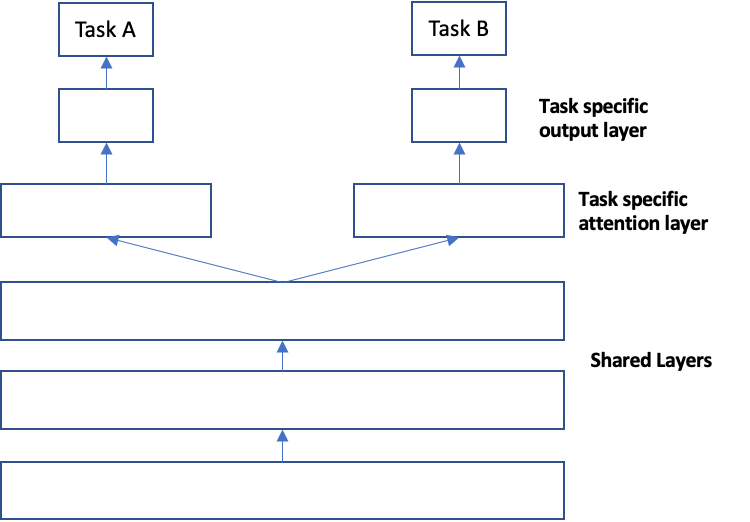

In addition to the hard parameter sharing layers for both tasks, an attention layer that is task specific is implemented after the shared layers. The attention layer is supposed to learn task specific weights during training and apply task specific attention to the two tasks at the output. This means the weights learned will scale the shared features that is coming from the output of the hidden layers according to the task (similar to feature selection from the shared features output that are more important for task specific prediction). This gives some flexibility to learn task specific context in addition to the weights learned in the shared layers for both tasks.

Similar to Section 5, the same network architecture is implemented in the shared layers and the only difference is the attention layer with task specific weights (to be learned during training) implemented before the output of each task.For the training, the hyperparameters lambda_1 and lambda_2 of 0.5 is used to test the strategy. The performance results of the model on the validation datset are shown below. It can be seen that there is a slight improvement in the performance compared to just using hard parameter sharing MTL model in Section 5 for the lambda_1 and lambda_2 values of 0.5.

In [42]:
# Task Specific Attention based MTL model using shared hidden layers
class AttentionLayer(nn.Module):
    def __init__(self, input_size, n_tasks):
        super().__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_size, n_tasks))

    def forward(self, x, task):
        # Apply attention weights for the specific task
        x = x * self.attention_weights[:, task-1]
        return x

class MultiTaskNeuralNetwork2(nn.Module):
    def __init__(self, n_classes_task1, n_classes_task2):
        super().__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.3)
        
        # Attention layer
        self.attention = AttentionLayer(128, 2)
        
        # Task-specific output layers
        self.out_task1 = nn.Linear(128, n_classes_task1)
        self.out_task2 = nn.Linear(128, n_classes_task2)
        
    def forward(self, x, task):
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # Apply the attention layer
        x = self.attention(x, task)

        # Task-specific outputs
        if task == 1:
            return self.out_task1(x)
        if task == 2:
            return self.out_task2(x)

In [553]:
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

lambda_1 = 0.5
lambda_2 = 0.5
epochs = 20

model2 = MultiTaskNeuralNetwork2(n_classes_task1=2, n_classes_task2=3)

# Define separate loss functions for each task
criterion_task1 = nn.CrossEntropyLoss()
criterion_task2 = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2]

        # Forward pass
        outputs_task1 = model2(input1, task=1)
        outputs_task2 = model2(input2, task=2)
        
        # Compute the losses for each task
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Combine the losses with the hyperparameters as factors
        loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

Epoch 1, Loss: 0.5302971888647535
Epoch 2, Loss: 0.4337948310891154
Epoch 3, Loss: 0.4129075544434419
Epoch 4, Loss: 0.4021008241420998
Epoch 5, Loss: 0.39512368873746084
Epoch 6, Loss: 0.38888380990484583
Epoch 7, Loss: 0.3851479219276976
Epoch 8, Loss: 0.380165342046351
Epoch 9, Loss: 0.37597528052492946
Epoch 10, Loss: 0.3724942563402897
Epoch 11, Loss: 0.3671983171568373
Epoch 12, Loss: 0.36641661425657857
Epoch 13, Loss: 0.36098140858300454
Epoch 14, Loss: 0.35773462253985483
Epoch 15, Loss: 0.3545935908183965
Epoch 16, Loss: 0.3485953749448129
Epoch 17, Loss: 0.3463942201167413
Epoch 18, Loss: 0.34288888300741455
Epoch 19, Loss: 0.3383667714435582
Epoch 20, Loss: 0.3368120429048777


In [556]:
torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

truth1 = []
truth2 = []
class_probs_t1 = []
class_probs_t2 = []
class_preds_t1 = []
class_preds_t2 = []

with torch.no_grad():
    for data in D1_hat_val_dataloader:
        x, y1, y2 = data
        output_t1 = model2(x, task = 1)
        output_t2 = model2(x, task = 2)

        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
        class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]
        
        _, class_preds_t1_batch = torch.max(output_t1, 1)
        _, class_preds_t2_batch = torch.max(output_t2, 1)

        class_probs_t1.append(class_probs_t1_batch)
        class_probs_t2.append(class_probs_t2_batch)
        
        class_preds_t1.append(class_preds_t1_batch)
        class_preds_t2.append(class_preds_t2_batch)
        
        truth1.extend([l.item() for l in y1])
        truth2.extend([l.item() for l in y2])

val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
val_preds_t1 = torch.cat(class_preds_t1)
val_preds_t2 = torch.cat(class_preds_t2)

In [557]:
perf_t1_model2 = f1_score(truth1, val_preds_t1)
print(f'The f1 score of attention based  based on the first task is {perf_t1_model2}')



The f1 score of attention based  based on the first task is 0.7524590163934425


The model is then hyperparameter tuned to assess the best lambda values that give the best performance for our primary task 1. The results of the hyperparamter tuning of the model is shown below.

In [43]:
# function to train and evaluate model for each lambda for attention based MTL model
def train_and_evaluate_model_2(lambda_1, lambda_2, train_dataloader, val_dataloader):
    
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    model2 = MultiTaskNeuralNetwork2(n_classes_task1=2, n_classes_task2=3)

    epochs = 20

    # Define separate loss functions for each task
    criterion_task1 = nn.CrossEntropyLoss()
    criterion_task2 = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        for (inputs, labels_task1, labels_task2) in train_dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            idx1 = labels_task1 != np.nan
            idx2 = labels_task2 != np.nan
            input1 = inputs[idx1]
            input2 = inputs[idx2]

            # Forward pass
            outputs_task1 = model2(input1, task=1)
            outputs_task2 = model2(input2, task=2)

            # Compute the losses for each task
            loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
            loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

            # Combine the losses with the hyperparameters as factors
            loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the running loss
            running_loss += loss.item()

        # # Print the average loss for this epoch
        #print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

    #Evalution of model
    torch.manual_seed(rng)
    torch.cuda.manual_seed(rng)
    torch.cuda.manual_seed_all(rng)
    np.random.seed(rng)
    random.seed(rng)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    truth1 = []
    truth2 = []
    class_probs_t1 = []
    class_probs_t2 = []
    class_preds_t1 = []
    class_preds_t2 = []
    
    with torch.no_grad():
        for data in val_dataloader:
            x, y1, y2 = data
            output_t1 = model2(x, task = 1)
            output_t2 = model2(x, task = 2)

            class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]
            class_probs_t2_batch = [nn.Softmax(dim=0)(el) for el in output_t2]

            _, class_preds_t1_batch = torch.max(output_t1, 1)
            _, class_preds_t2_batch = torch.max(output_t2, 1)

            class_probs_t1.append(class_probs_t1_batch)
            class_probs_t2.append(class_probs_t2_batch)

            class_preds_t1.append(class_preds_t1_batch)
            class_preds_t2.append(class_preds_t2_batch)

            truth1.extend([l.item() for l in y1])
            truth2.extend([l.item() for l in y2])

    val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
    val_probs_t2 = torch.cat([torch.stack(batch) for batch in class_probs_t2])
    val_preds_t1 = torch.cat(class_preds_t1)
    val_preds_t2 = torch.cat(class_preds_t2)    
    
    perf_t1_model2 = f1_score(truth1, val_preds_t1)
    perf_t2_model2 = accuracy_score(truth2, val_preds_t2)    

    return perf_t1_model2, perf_t2_model2


In [44]:
# Gridsearch to find optimal lambda for obtaining best task 1 performance on 
# attention based MTL model
lambda_1_list = [0, 0.25, 0.5, 0.75, 1.0] 
lambda_2_list = [0, 0.25, 0.5, 0.75, 1.0]
best_lambda_1 = None
best_lambda_2 = None
best_t1_val_perf = 0

## Run all combinations of lambda1 and lambda2 to find best combination for best 
## T1 performance
for lambda_1 in lambda_1_list:

    for lambda_2 in lambda_2_list:
        
        task1_val_perf, task2_val_perf = train_and_evaluate_model_2(lambda_1, lambda_2, D12_train_dataloader, D1_hat_val_dataloader)
        
        print(f"Lambda_1: {lambda_1}, Lambda_2: {lambda_2}, Task 1 Validation f1_score: {task1_val_perf}")
        
        if task1_val_perf > best_t1_val_perf:
            best_t1_val_perf = task1_val_perf
            best_lambda_1 = lambda_1
            best_lambda_2 = lambda_2

Lambda_1: 0, Lambda_2: 0, Task 1 Validation f1_score: 0.28349944629014395
Lambda_1: 0, Lambda_2: 0.25, Task 1 Validation f1_score: 0.41042893187552565
Lambda_1: 0, Lambda_2: 0.5, Task 1 Validation f1_score: 0.47008547008547
Lambda_1: 0, Lambda_2: 0.75, Task 1 Validation f1_score: 0.4167350287120591
Lambda_1: 0, Lambda_2: 1.0, Task 1 Validation f1_score: 0.4328593996840442
Lambda_1: 0.25, Lambda_2: 0, Task 1 Validation f1_score: 0.7510917030567685
Lambda_1: 0.25, Lambda_2: 0.25, Task 1 Validation f1_score: 0.7607260726072608
Lambda_1: 0.25, Lambda_2: 0.5, Task 1 Validation f1_score: 0.7516556291390728
Lambda_1: 0.25, Lambda_2: 0.75, Task 1 Validation f1_score: 0.75
Lambda_1: 0.25, Lambda_2: 1.0, Task 1 Validation f1_score: 0.7474916387959866
Lambda_1: 0.5, Lambda_2: 0, Task 1 Validation f1_score: 0.7622259696458683
Lambda_1: 0.5, Lambda_2: 0.25, Task 1 Validation f1_score: 0.7462932454695222
Lambda_1: 0.5, Lambda_2: 0.5, Task 1 Validation f1_score: 0.7524590163934425
Lambda_1: 0.5, Lamb

In [45]:
print(f"The best lambda_1 value is: {best_lambda_1}")
print(f"The best lambda_2 value is: {best_lambda_2}")

The best lambda_1 value is: 0.5
The best lambda_2 value is: 0


The best hyperparameters for lambda_1 and lambda_2 are 0.5 and 0 respectively which gives the best performance for task 1 on the validation dataset. The performance of the model is also better for task 1 compared to the model trained only on D1 dataset in Section 1. The performance of the model is also better than the hyperparameter tuned hard parameter sharing model detailed in Section 6.

As discussed in Section 8, lambda2 = 0 (loss function is only based on task 1 loss) in this MTL model gives the best performance for predicting task 1 as all the attention is given to task 1 when training the model.

These optimised lambdas were used to re-train the MTL model. The re-trained optimised for task 1 model is then used to predict the labels for the D1 test dataset to be submitted in Kaggle.

In [46]:
# Final attention based MTL model with lambda1= 0.5 and lambda2= 0

torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

lambda_1 = 0.5
lambda_2 = 0
epochs = 20

model2 = MultiTaskNeuralNetwork2(n_classes_task1=2, n_classes_task2=3)

# Define separate loss functions for each task
criterion_task1 = nn.CrossEntropyLoss()
criterion_task2 = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for (inputs, labels_task1, labels_task2) in D12_train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        idx1 = labels_task1 != np.nan
        idx2 = labels_task2 != np.nan
        input1 = inputs[idx1]
        input2 = inputs[idx2]

        # Forward pass
        outputs_task1 = model2(input1, task=1)
        outputs_task2 = model2(input2, task=2)

        # Compute the losses for each task
        loss_task1 = criterion_task1(outputs_task1, (labels_task1[idx1]).type(torch.LongTensor))
        loss_task2 = criterion_task2(outputs_task2, (labels_task2[idx2]).type(torch.LongTensor))

        # Combine the losses with the hyperparameters as factors
        loss = lambda_1 * loss_task1 + lambda_2 * loss_task2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(D12_train_dataloader)}")

Epoch 1, Loss: 0.08695137546162263
Epoch 2, Loss: 0.061206184484590705
Epoch 3, Loss: 0.058621256803173004
Epoch 4, Loss: 0.05705142860112029
Epoch 5, Loss: 0.05526326881013047
Epoch 6, Loss: 0.05389934435384963
Epoch 7, Loss: 0.05316305579935839
Epoch 8, Loss: 0.0522527131591425
Epoch 9, Loss: 0.05122248517192374
Epoch 10, Loss: 0.050608612104809096
Epoch 11, Loss: 0.049534805750570864
Epoch 12, Loss: 0.04931032584220646
Epoch 13, Loss: 0.04798620392447486
Epoch 14, Loss: 0.04662113573512482
Epoch 15, Loss: 0.046010353493213585
Epoch 16, Loss: 0.04476061545615774
Epoch 17, Loss: 0.04419420524616991
Epoch 18, Loss: 0.04273271106463562
Epoch 19, Loss: 0.041674643961801816
Epoch 20, Loss: 0.04114870229844165


In [ ]:
#prediction of test dataset using re-trained model and save results to csv file
# to upload in kaggle

torch.manual_seed(rng)
torch.cuda.manual_seed(rng)
torch.cuda.manual_seed_all(rng)
np.random.seed(rng)
random.seed(rng)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


class_probs_t1 = []
class_preds_t1 = []
with torch.no_grad():
    for data in test_dataloader:
        x = data
        output_t1 = model2(x[0], task = 1)

        class_probs_t1_batch = [nn.Softmax(dim=0)(el) for el in output_t1]

        _, class_preds_t1_batch = torch.max(output_t1, 1)

        class_probs_t1.append(class_probs_t1_batch)
        
        class_preds_t1.append(class_preds_t1_batch)


#predictions of D1 test data
val_probs_t1 = torch.cat([torch.stack(batch) for batch in class_probs_t1])
val_preds_t1 = torch.cat(class_preds_t1).numpy()

#write prediction of test data to output for submission to kaggle
df_d1_atten_test_preds = df_d1_test_final
df_d1_atten_test_preds['target'] = val_preds_t1.tolist()
df_d1_atten_test_preds = df_d1_atten_test_preds.drop(['text', 'sentence_embeddings'], axis=1)
df_d1_atten_test_preds.to_csv('test_atten_parameter.csv', index=False)

### The model resulted in Score of 80.04% in Kaggle.(Please refer screenshot in the zip file)

Since we have the attention based layer to scale the shared features according to the task, it can be argued that hyper parameters may not be needed. This can be tested by observing the performance of the model for lambda1 = 1 and lambda2 = 1. The f1 score for task 1 on the validation data is about 0.752 (results of the gridsearch). However, by hyperparameter tuning, we can get better results with lambda1=0.5 and lambda2=0 with a f1 score of 0.7622. Therefore, even though we have the attention layer to help the model learn task specific features, the hyper parameters further improve in improving the performance of primary task 1.